# SDSU Climate Informatics Lab

## FourCastNet
$\hspace{1cm}$ The lab is connected to SDSU's compputational resources so that students will be able to continue working with large data and performing computational experiments which would not have been possible in the past. This notebook will assist students in gaining some general familiarity with SDSU's resources and producing some images to be further understand how NVIDA's FourCastNet can be used by more students and universities with just a few GPU's.

## Loading Libraries
To run FourCastNet you will need to import a few libraries first.

In [1]:
# libraries
import os, sys, time
import numpy as np
import h5py
import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.ticker import FuncFormatter

## Setting appropriate paths

You will need to change the paths to your directory locations to be able to access the correct files. The data should come from some folder which contains the ERA5 data which can be downloaded from the Globus download links: 
* [Pre-processed Training Data](https://app.globus.org/file-manager?origin_id=945b3c9e-0f8c-11ed-8daf-9f359c660fbd&origin_path=%2F~%2Fdata%2F),
* [Trained Model Weights - Globus Download Link](https://app.globus.org/file-manager?origin_id=945b3c9e-0f8c-11ed-8daf-9f359c660fbd&origin_path=%2F~%2Fmodel_weights%2F)


In [2]:
# data and model paths
data_path = "/home/jovyan/shared/fourcastnet/FourCastNet/data/FCN_ERA5_data_v0/out_of_sample"
data_file = os.path.join(data_path, "2018.h5")
model_path = "/home/jovyan/shared/fourcastnet/FourCastNet/model_weights/FCN_weights_v0/backbone.ckpt"
global_means_path = "/home/jovyan/shared/fourcastnet/FourCastNet/additional/stats_v0/global_means.npy"
global_stds_path = "/home/jovyan/shared/fourcastnet/FourCastNet/additional/stats_v0/global_stds.npy"
time_means_path = "/home/jovyan/shared/fourcastnet/FourCastNet/additional/stats_v0/time_means.npy"
land_sea_mask_path = "/home/jovyan/shared/fourcastnet/FourCastNet/additional/stats_v0/land_sea_mask.npy"

## ERA5 data

The following variables names are used to reference the fields which are in the dataset as well as the fields which FourCastNet will track. The code below displays the size of the data as well as the fields in a Robinson projection with continetal outlines. Note that units may be adjusted for particular fields. The terms ```variables_to_plot``` and ```colormaps``` can be adjusted in lines 19 and 20. The total data shape will print as ```(1460, 21, 721, 1440)``` where 1460 corresponds to the amount of 6-hour time steps in a year, 21 is the variables to be plotted, and the 2D field is 721x1440 pixels.

The variable keys are as follows:

* u10: zonal wind at 10m from surface
* v10: meridional wind at 10m from surface
* t2m: temperature at 2m from surface
* sp: surface pressure
* msl: pressure reduced to mean sea level
* tcwv: total / integrated column of atmospheric water vapor content
* u1000 (850, 500): zonal wind at pressure level 1000hPa (850hPa, 500hPa)
* v1000 (850, 500): meridional wind at pressure level 1000hPa (850hPa, 500hPa)
* t1000 (850, 500): temperature at pressure level 1000hPa (850hPa, 500hPa)
* z1000 (850, 500, 50): geopotential height at pressure level 1000hPa (850hPa, 500hPa, 50hPa)
* r500, r850: relative humidity at 500hPa, 850hPa


Total data shape: (1460, 21, 721, 1440)


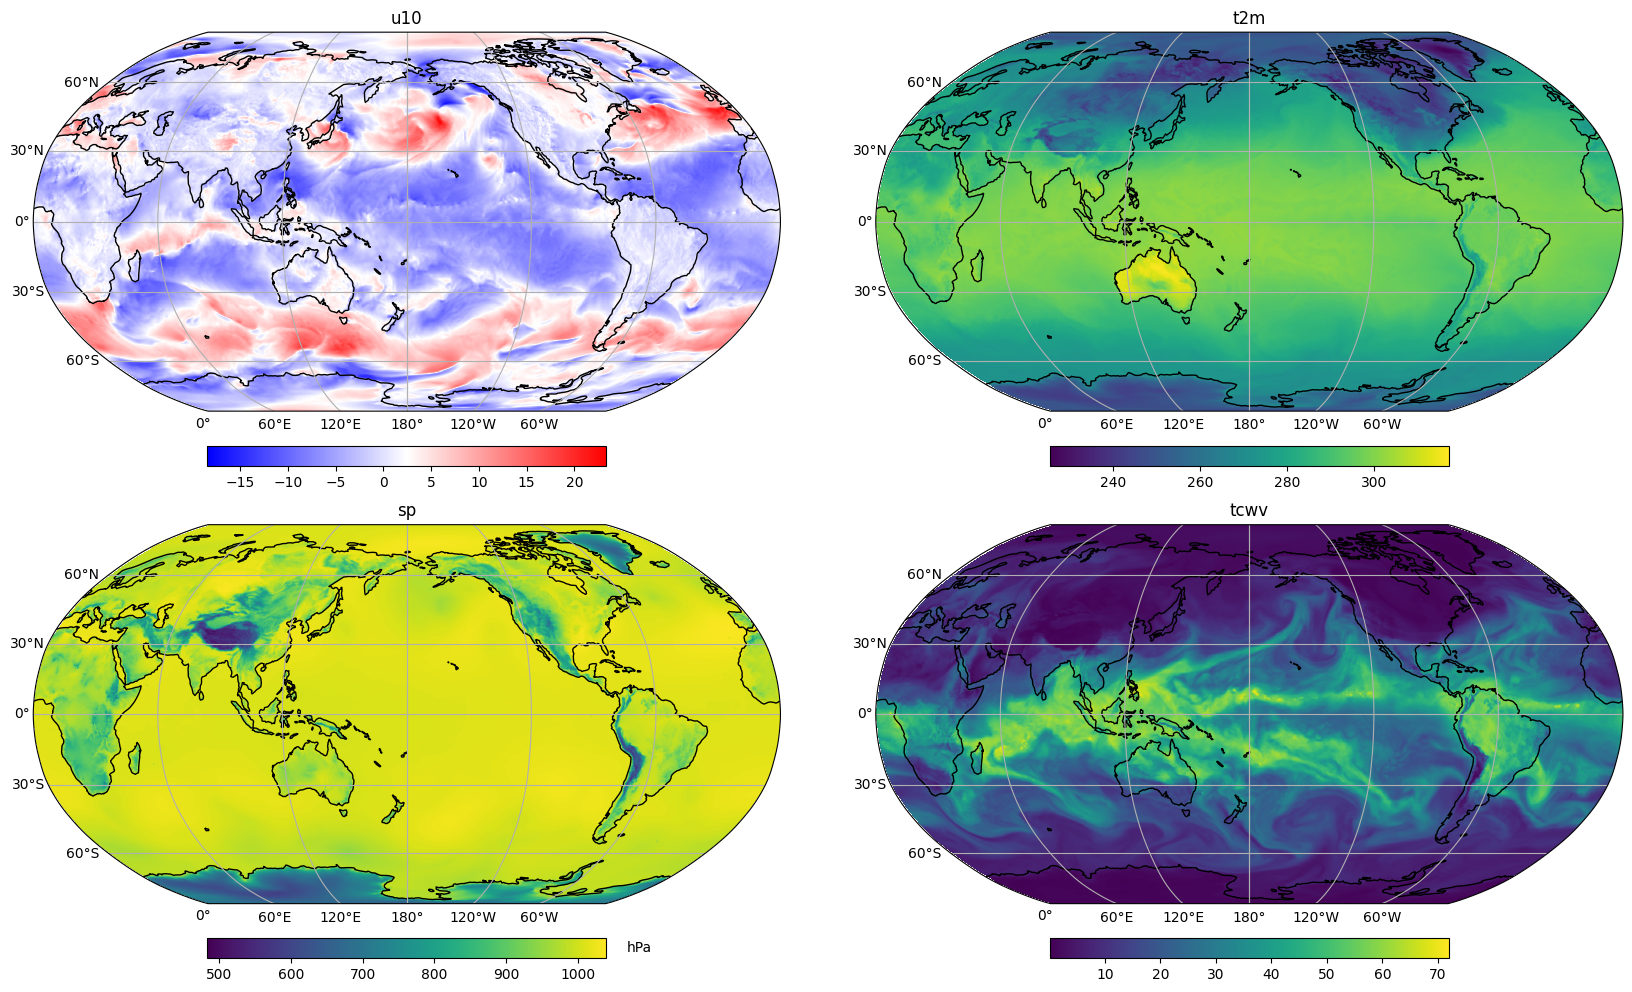

In [3]:
# Define the atmospheric variables and their ordering
variables = ['u10', 'v10', 't2m', 'sp', 'msl', 't850', 'u1000', 'v1000', 'z1000',
             'u850', 'v850', 'z850', 'u500', 'v500', 'z500', 't500', 'z50', 'r500', 'r850', 'tcwv']

sample_data = h5py.File(data_file, 'r')['fields']
print('Total data shape:', sample_data.shape)

# Select a timestep index to visualize
timestep_idx = 1



# Create subplots with the Robinson projection centered on the Pacific (central_longitude=180)
central_longitude = 180
projection = ccrs.Robinson(central_longitude=central_longitude)
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(17, 10), subplot_kw={'projection': projection})

# List of variables to plot and their corresponding colormaps
variables_to_plot = ['u10', 't2m', 'sp', 'tcwv']
colormaps = ['bwr', 'viridis', 'viridis', 'viridis']

# Define the extent of the map (in degrees)
extent = (-180, 180, -90, 90)

# Formatter function to convert Pa to hPa
def pa_to_hpa(x, pos):
    return f'{x * 0.01:.0f}'


# Plot a grid of fields
for i, (varname, cmap) in enumerate(zip(variables_to_plot, colormaps)):
    varidx = variables.index(varname)
    data = sample_data[timestep_idx, varidx]

    ax[i//2][i%2].set_global()
    im = ax[i//2][i%2].imshow(np.roll(data, shift=data.shape[-1]//2, axis=-1),
                              transform=ccrs.PlateCarree(), cmap=cmap, extent=extent, origin='upper')
    ax[i//2][i%2].coastlines()
    ax[i//2][i%2].set_title(varname)
    
    # Create the colorbar with custom formatter for hPa
    cbar = fig.colorbar(im, ax=ax[i//2][i%2], orientation='horizontal', fraction=0.046, pad=0.08)
    if varname == 'sp':
        cbar.ax.xaxis.set_major_formatter(FuncFormatter(pa_to_hpa))
        cbar.ax.text(1.05, 0.5, 'hPa', rotation=0, transform=cbar.ax.transAxes, va='center', ha='left')
        
    gl = ax[i//2][i%2].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False


fig.tight_layout()
plt.show()

## Loading the model

The following steps will allow you to load the model which you defined the path for earlier.
1. In line 20 of ```FourCastNet/networks/afnonet.py``` change ```from utils.img_utils import PeriodicPad2d``` to ```from FourCastNet.utils.img_utils import PeriodicPad2d```
2. Ensure that your model is being loaded correctly from the directory you are calling. You may find publicly accessible models available online which will allow you to avoid training time. Some initial images can come from the model_weights globus download as ```backbone.ckpt``` but this is not a fully trained model.

In [4]:
# Get the model config from default configs

os.chdir('/home/jovyan')
from FourCastNet.utils.YParams import YParams

config_file = "/home/jovyan/FourCastNet/config/AFNO.yaml"
config_name = "afno_backbone"
params = YParams(config_file, config_name)
print("Model architecture used = {}".format(params["nettype"]))

Model architecture used = afno


In [5]:
# import model
from FourCastNet.networks.afnonet import AFNONet
from collections import OrderedDict

def load_model(model, params, checkpoint_file):
    ''' helper function to load model weights '''
    checkpoint_fname = checkpoint_file
    checkpoint = torch.load(checkpoint_fname)
    try:
        ''' FourCastNet is trained with distributed data parallel
            (DDP) which prepends 'module' to all keys. Non-DDP
            models need to strip this prefix '''
        new_state_dict = OrderedDict()
        for key, val in checkpoint['model_state'].items():
            name = key[7:]
            if name != 'ged':
                new_state_dict[name] = val
        model.load_state_dict(new_state_dict)
    except:
        model.load_state_dict(checkpoint['model_state'])
    model.eval() # set to inference mode
    return model

device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'

# in and out channels: FourCastNet uses 20 input channels corresponding to 20 prognostic variables
in_channels = np.array(params.in_channels)
out_channels = np.array(params.out_channels)
params['N_in_channels'] = len(in_channels)
params['N_out_channels'] = len(out_channels)
params.means = np.load(global_means_path)[0, out_channels] # for normalizing data with precomputed train stats
params.stds = np.load(global_stds_path)[0, out_channels]
params.time_means = np.load(time_means_path)[0, out_channels]

# load the model
if params.nettype == 'afno':
    model = AFNONet(params).to(device)  # AFNO model
else:
    raise Exception("not implemented")
# load saved model weights
model = load_model(model, params, model_path)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Mean and Standard Deviation loaded

In [6]:
# move normalization tensors to gpu
# load time means: represents climatology
img_shape_x = 720
img_shape_y = 1440

# means and stds over training data
means = params.means
stds = params.stds

# load climatological means
time_means = params.time_means # temporal mean (for every pixel)
m = torch.as_tensor((time_means - means)/stds)[:, 0:img_shape_x]
m = torch.unsqueeze(m, 0)
# these are needed to compute ACC and RMSE metrics
m = m.to(device, dtype=torch.float)
std = torch.as_tensor(stds[:,0,0]).to(device, dtype=torch.float)

print("Shape of time means = {}".format(m.shape))
print("Shape of std = {}".format(std.shape))

Shape of time means = torch.Size([1, 20, 720, 1440])
Shape of std = torch.Size([20])


## Metrics for evaluating the forecast

NVIDIA uses ACC and RMSE to evaluate the quality of forecasts. The code block below createes functions to compute these values.

In [7]:
# define metrics from the definitions above
def lat(j: torch.Tensor, num_lat: int) -> torch.Tensor:
    return 90. - j * 180./float(num_lat-1)

def latitude_weighting_factor(j: torch.Tensor, num_lat: int, s: torch.Tensor) -> torch.Tensor:
    return num_lat * torch.cos(3.1416/180. * lat(j, num_lat))/s

def weighted_rmse_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    #takes in arrays of size [n, c, h, w]  and returns latitude-weighted rmse for each channel
    num_lat = pred.shape[2]
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)
    s = torch.sum(torch.cos(3.1416/180. * lat(lat_t, num_lat)))
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))
    result = torch.sqrt(torch.mean(weight * (pred - target)**2., dim=(-1,-2)))
    return result

def weighted_acc_channels(pred: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    #takes in arrays of size [n, c, h, w]  and returns latitude-weighted acc for each channel
    num_lat = pred.shape[2]
    lat_t = torch.arange(start=0, end=num_lat, device=pred.device)
    s = torch.sum(torch.cos(3.1416/180. * lat(lat_t, num_lat)))
    weight = torch.reshape(latitude_weighting_factor(lat_t, num_lat, s), (1, 1, -1, 1))
    result = torch.sum(weight * pred * target, dim=(-1,-2)) / torch.sqrt(torch.sum(weight * pred * pred, dim=(-1,-2)) * torch.sum(weight * target *
    target, dim=(-1,-2)))
    return result

## Inference

In [8]:
# autoregressive inference helper

def inference(data_slice, model, prediction_length, idx):
    # create memory for the different stats
    n_out_channels = params['N_out_channels']
    acc = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)
    rmse = torch.zeros((prediction_length, n_out_channels)).to(device, dtype=torch.float)

    # to conserve GPU mem, only save one channel (can be changed if sufficient GPU mem or move to CPU)
    targets = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)
    predictions = torch.zeros((prediction_length, 1, img_shape_x, img_shape_y)).to(device, dtype=torch.float)


    with torch.no_grad():
        for i in range(data_slice.shape[0]):
            if i == 0:
                first = data_slice[0:1]
                future = data_slice[1:2]
                pred = first
                tar = first
                # also save out predictions for visualizing channel index idx
                targets[0,0] = first[0,idx]
                predictions[0,0] = first[0,idx]
                # predict
                future_pred = model(first)
            else:
                if i < prediction_length - 1:
                    future = data_slice[i+1:i+2]
                future_pred = model(future_pred) # autoregressive step

            if i < prediction_length - 1:
                predictions[i+1,0] = future_pred[0,idx]
                targets[i+1,0] = future[0,idx]

            # compute metrics using the ground truth ERA5 data as "true" predictions
            rmse[i] = weighted_rmse_channels(pred, tar) * std
            acc[i] = weighted_acc_channels(pred-m, tar-m)
            print('Predicted timestep {} of {}. {} RMS Error: {}, ACC: {}'.format(i, prediction_length, field, rmse[i,idx], acc[i,idx]))

            pred = future_pred
            tar = future

    # copy to cpu for plotting/vis
    acc_cpu = acc.cpu().numpy()
    rmse_cpu = rmse.cpu().numpy()
    predictions_cpu = predictions.cpu().numpy()
    targets_cpu = targets.cpu().numpy()

    return acc_cpu, rmse_cpu, predictions_cpu, targets_cpu

In [11]:
# setup data for inference
dt = 1 # time step (x 6 hours)
ic = 0 # start the inference from here
prediction_length = 20 # number of steps (x 6 hours)

# which field to track for visualization
field = 't2m'
idx_vis = variables.index(field) # also prints out metrics for this field

# get prediction length slice from the data
print('Loading inference data')
print('Inference data from {}'.format(data_file))
data = h5py.File(data_file, 'r')['fields'][ic:(ic+prediction_length*dt):dt,in_channels,0:img_shape_x]
print(datamsl.shape)
print("Shape of data = {}".format(datamsl.shape))

Loading inference data
Inference data from /home/jovyan/shared/fourcastnet/FourCastNet/data/FCN_ERA5_data_v0/out_of_sample/2018.h5
(20, 20, 720, 1440)
Shape of data = (20, 20, 720, 1440)


This next cell is what will perform the actual prediction for the given variable in the cell above, we use temperature at 2 meters as an example. Changes can be made to track all variables at once if GPU memory allows. The variable ```predictions_cpu``` represents FourCastNet and ```targets_cpu``` represents the ERA5 data.

In [12]:
# run inference
data = (data - means)/stds # standardize the data
data = torch.as_tensor(data).to(device, dtype=torch.float) # move to gpu for inference
acc_cpu, rmse_cpu, predictions_cpu, targets_cpu = inference(data, model, prediction_length, idx=idx_vis)

Predicted timestep 0 of 20. t2m RMS Error: 0.0, ACC: 1.0
Predicted timestep 1 of 20. t2m RMS Error: 0.7502886652946472, ACC: 0.9969217777252197
Predicted timestep 2 of 20. t2m RMS Error: 0.8730393648147583, ACC: 0.9957135915756226
Predicted timestep 3 of 20. t2m RMS Error: 0.9343942999839783, ACC: 0.9950178861618042
Predicted timestep 4 of 20. t2m RMS Error: 0.977485716342926, ACC: 0.9949643611907959
Predicted timestep 5 of 20. t2m RMS Error: 1.0328102111816406, ACC: 0.9941376447677612
Predicted timestep 6 of 20. t2m RMS Error: 1.0622789859771729, ACC: 0.9933986067771912
Predicted timestep 7 of 20. t2m RMS Error: 1.1065069437026978, ACC: 0.992759644985199
Predicted timestep 8 of 20. t2m RMS Error: 1.1468467712402344, ACC: 0.9929141998291016
Predicted timestep 9 of 20. t2m RMS Error: 1.1875436305999756, ACC: 0.9921593070030212
Predicted timestep 10 of 20. t2m RMS Error: 1.2584391832351685, ACC: 0.990827202796936
Predicted timestep 11 of 20. t2m RMS Error: 1.2995293140411377, ACC: 0.9903

## Evaluating the Model

To evaluate the model we can plot ACC, Anomaly Correlation Coefficient, and RMSE, Root Mean Squared Error. If we note the ACC dips below 0.6 the forecast is not reliable after $n$ time steps. We show the evaluation of the ```u10``` field for ACC and RMSE. 

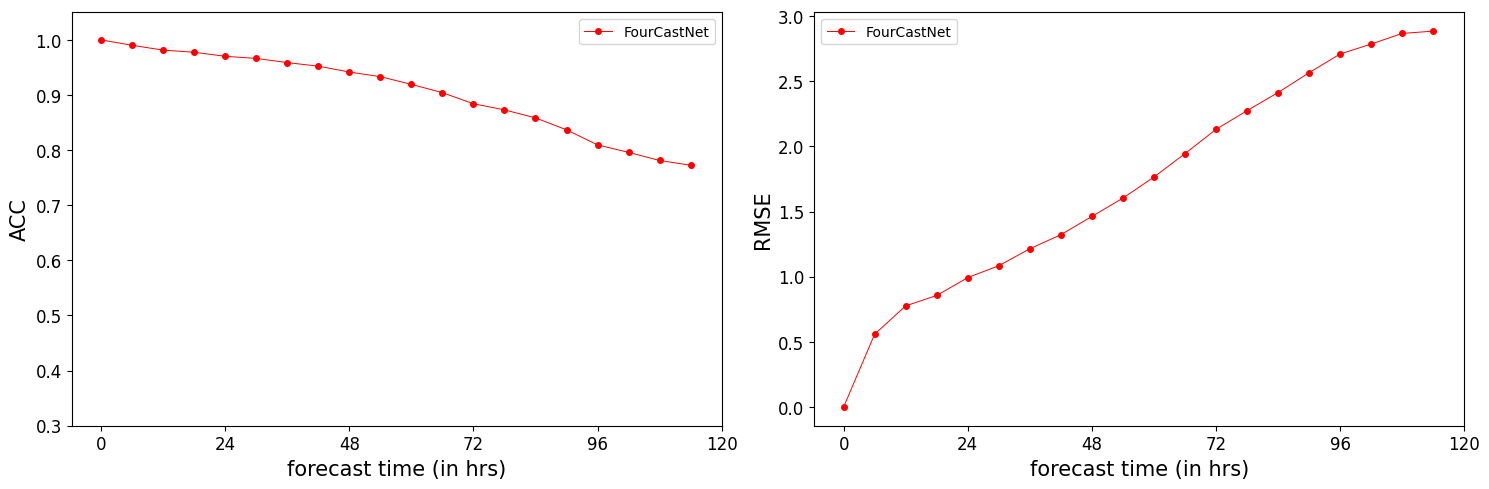

In [13]:
# plot the acc and rmse metrics
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
start = 0
end = prediction_length #  < prediction_lenght forecast

field = 'u10' # change this to other fields such as z500
idx_metric = variables.index(field) # plot metrics for this field

hrs = np.arange(0, end*6, 6)
ax[0].plot(hrs, acc_cpu[start:end,idx_metric], "o-", label="FourCastNet", ms=4, lw=0.7, color="r")
ax[1].plot(hrs, rmse_cpu[start:end,idx_metric], "o-", label="FourCastNet", ms=4, lw=0.7, color="r")
ax[0].legend()
ax[1].legend()
fsz = "15"
xlist = np.arange(0,end*6+24,24)
ax[0].set_xlabel("forecast time (in hrs)", fontsize=fsz)
ax[1].set_xlabel("forecast time (in hrs)", fontsize=fsz)
ax[0].set_ylabel("ACC", fontsize=fsz)
ax[1].set_ylabel("RMSE", fontsize=fsz)
ax[0].set_ylim(0.3, 1.05)
ax[0].set_xticks(xlist)
ax[1].set_xticks(xlist)
ax[0].tick_params(axis='both', which='both', labelsize=12)
ax[1].tick_params(axis='both', which='both', labelsize=12)
fig.tight_layout()

## Visualizing the predictions

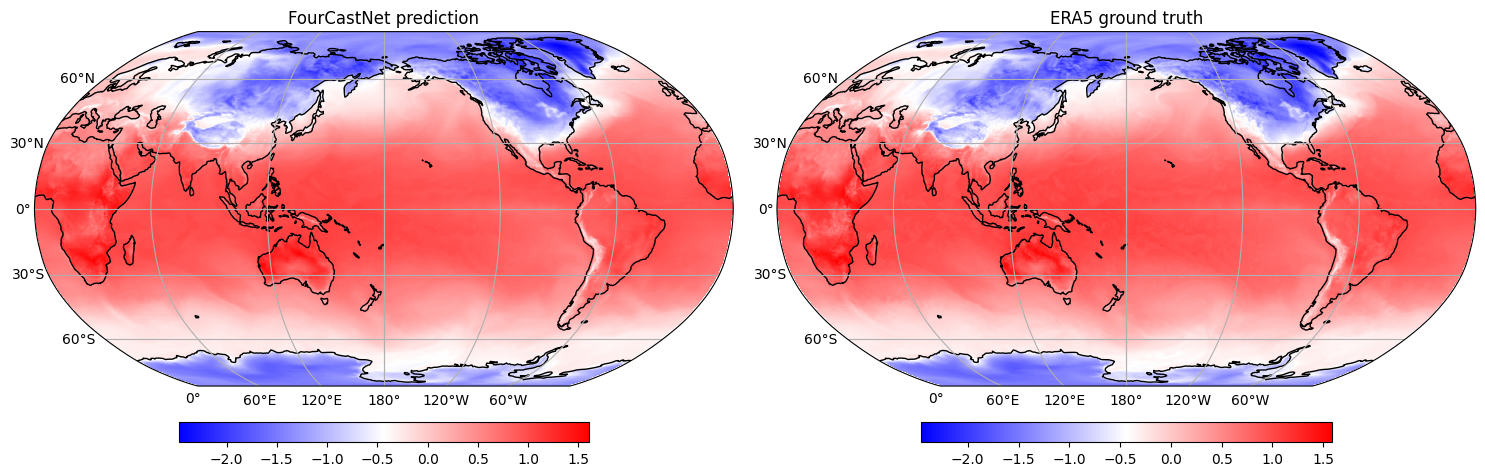

In [18]:
'''
We visualize the predicted variable and compare it to the ERA5 data.
Lead time is selected in this cell, in 6hour intervals.
'''


# Create subplots with the Robinson projection centered on the Pacific (central_longitude=180)
central_longitude = 180
projection = ccrs.Robinson(central_longitude=central_longitude)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), subplot_kw={'projection': projection})
t = 2  # at 2x6 hours lead time

# Define the extent of the map (in degrees)
extent = (-180, 180, -90, 90)

# Define the color limits
vmin, vmax = -2, 1

# Plot the prediction data
ax[0].set_global()
im1 = ax[0].imshow(np.roll(predictions_cpu[t, 0], shift=predictions_cpu.shape[-1]//2, axis=-1), 
                   transform=ccrs.PlateCarree(central_longitude=0), 
                   cmap="bwr", extent=extent, origin='upper')#, vmin=vmin, vmax=vmax)
ax[0].coastlines()
# ax[0].add_feature(cfeature.BORDERS)
ax[0].set_title("FourCastNet prediction")

# Plot the ground truth data
ax[1].set_global()
im2 = ax[1].imshow(np.roll(targets_cpu[t, 0], shift=targets_cpu.shape[-1]//2, axis=-1), 
                   transform=ccrs.PlateCarree(central_longitude=0), 
                   cmap="bwr", extent=extent, origin='upper')#, vmin=vmin, vmax=vmax)
ax[1].coastlines()
# ax[1].add_feature(cfeature.BORDERS)
ax[1].set_title("ERA5 ground truth")

# Add colorbar
fig.colorbar(im1, ax=ax[0], orientation='horizontal', fraction=0.046, pad=0.08)
fig.colorbar(im2, ax=ax[1], orientation='horizontal', fraction=0.046, pad=0.08)

for i in np.arange(2):
    gl = ax[i].gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels = False
    gl.right_labels = False

fig.tight_layout()
plt.show()


### Forecast accessibility for remote locations

One hope for the lab is that FourCastNet will be to able to provide reliable and accessible weather predictions for remote locations such as small islands. Such predictions would be able to allow for nations to give advanced warning for severe weather events, prepare for floods, or times of drought. At this stage our predictions seems to show very low resolution images. To check different locations use the following cell to adjust index of the data being visualized to match the overlay of the map being shown. ```extent``` will be the longitude and latitude index which you want to visualize. The output of the cell is what you will need to adjust for ```predictions_cpu[x,0][enter longitude and latitude indeces]``` when visualizing the data, where x is the forecast length.

In [53]:
# Data dimensions
img_shape_x = 720  # Number of latitude points
img_shape_y = 1440 # Number of longitude points

# Create arrays for longitude and latitude
lon_values = np.linspace(-180, 180, img_shape_y)
lat_values = np.linspace(-90, 90, img_shape_x)

def find_indices(extent, lon_values, lat_values):
    lon_min, lon_max, lat_min, lat_max = extent
    
    # Find indices for the extent
    lon_idx = np.where((lon_values >= lon_min) & (lon_values <= lon_max))[0]
    lat_idx = np.where((lat_values >= lat_min) & (lat_values <= lat_max))[0]
    
    if len(lon_idx) == 0 or len(lat_idx) == 0:
        raise ValueError("No data points found within the specified extent.")
    
    return lat_idx, lon_idx

# Define your extent [lon_min, lon_max, lat_min, lat_max]
extent = [-176, -174, -22, -20]

lat_idx, lon_idx = find_indices(extent, lon_values, lat_values)

print("Latitude indices:", lat_idx)
print("Longitude indices:", lon_idx)


Latitude indices: [272 273 274 275 276 277 278 279]
Longitude indices: [16 17 18 19 20 21 22 23]


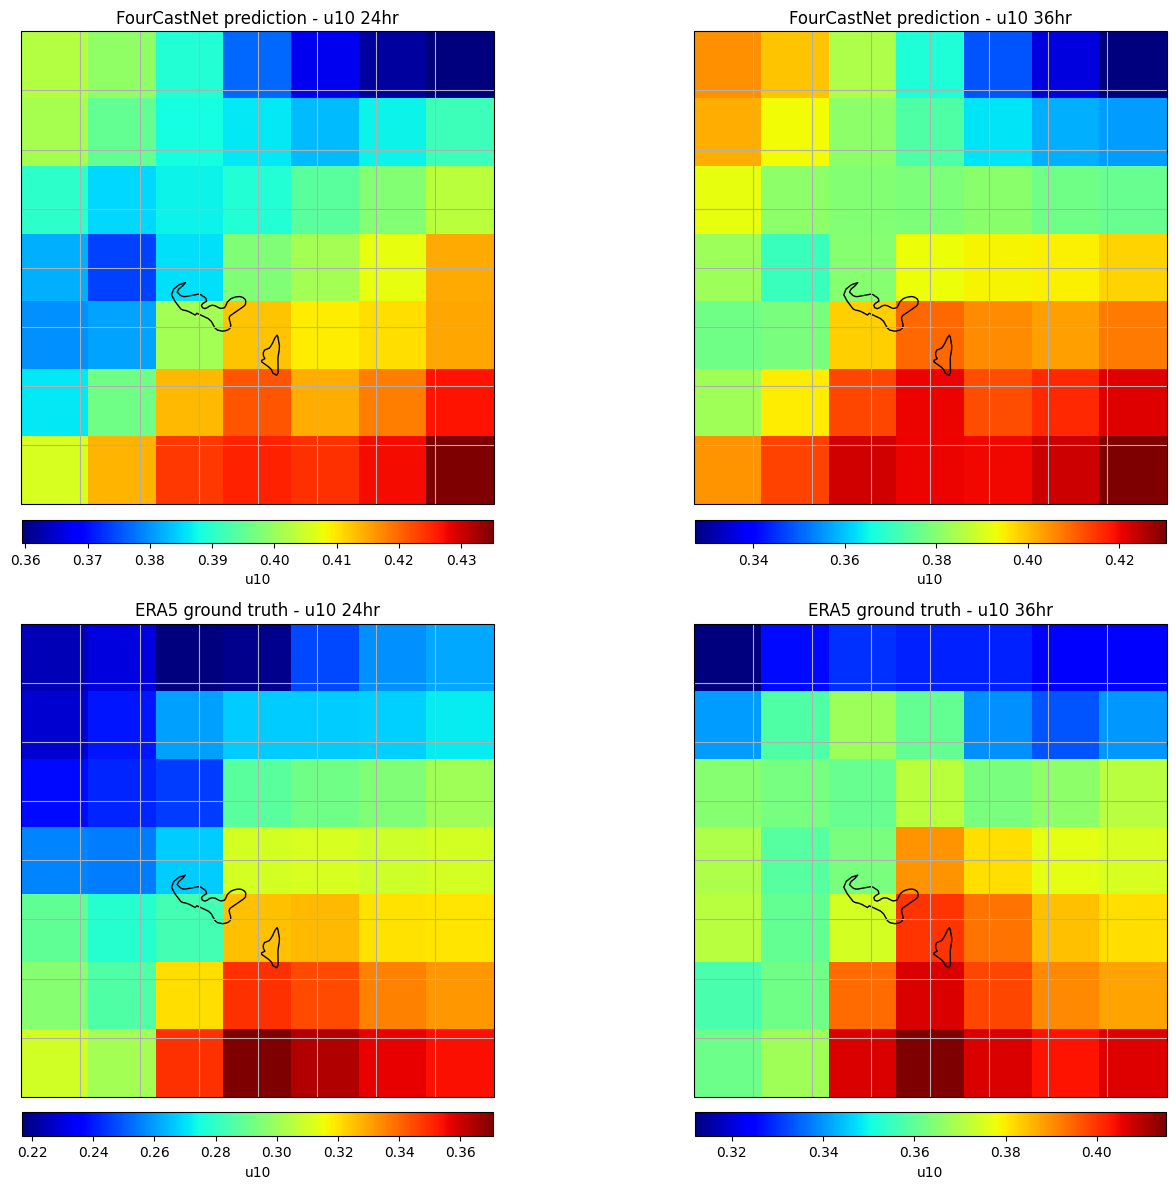

In [52]:
# Function to plot u10 field for the Tonga region
def plot_tonga_u10(predictions, targets):
    # Create subplots with the PlateCarree projection
    projection = ccrs.PlateCarree()

    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12), subplot_kw={'projection': projection})

    # Define the extent covering the Tonga region
    tonga_extent = [-176, -174, -22, -20]  # [lon_min, lon_max, lat_min, lat_max]

    # Plot predictions[4, 0]
    ax[0, 0].set_extent(tonga_extent, crs=ccrs.PlateCarree())
    im1 = ax[0, 0].imshow(predictions[4, 0][272:279,16:23], cmap='jet', extent=tonga_extent, transform=ccrs.PlateCarree())
    ax[0, 0].coastlines()
    ax[0, 0].set_title("FourCastNet prediction - u10 24hr")
    ax[0, 0].gridlines()

    # Plot predictions[12, 0]
    ax[0, 1].set_extent(tonga_extent, crs=ccrs.PlateCarree())
    im2 = ax[0, 1].imshow(predictions[12, 0][272:279,16:23], cmap='jet', extent=tonga_extent, transform=ccrs.PlateCarree())
    ax[0, 1].coastlines()
    ax[0, 1].set_title("FourCastNet prediction - u10 36hr")
    ax[0, 1].gridlines()

    # Plot targets[4, 0]
    ax[1, 0].set_extent(tonga_extent, crs=ccrs.PlateCarree())
    im3 = ax[1, 0].imshow(targets[4, 0][272:279,16:23], cmap='jet', extent=tonga_extent, transform=ccrs.PlateCarree())
    ax[1, 0].coastlines()
    ax[1, 0].set_title("ERA5 ground truth - u10 24hr")
    ax[1, 0].gridlines()

    # Plot targets[12, 0]
    ax[1, 1].set_extent(tonga_extent, crs=ccrs.PlateCarree())
    im4 = ax[1, 1].imshow(targets[12, 0][272:279,16:23], cmap='jet', extent=tonga_extent, transform=ccrs.PlateCarree())
    ax[1, 1].coastlines()
    ax[1, 1].set_title("ERA5 ground truth - u10 36hr")
    ax[1, 1].gridlines()

    # Add colorbars
    fig.colorbar(im1, ax=ax[0, 0], orientation='horizontal', fraction=0.046, label='u10', pad=0.03)
    fig.colorbar(im2, ax=ax[0, 1], orientation='horizontal', fraction=0.046, label='u10', pad=0.03)
    fig.colorbar(im3, ax=ax[1, 0], orientation='horizontal', fraction=0.046, label='u10', pad=0.03)
    fig.colorbar(im4, ax=ax[1, 1], orientation='horizontal', fraction=0.046, label='u10', pad=0.03)

    plt.tight_layout()
    plt.show()

# Call the function with your actual data
plot_tonga_u10(predictions_cpu, targets_cpu)


## Potential Questions

This user guide allows for students to gain some initial insight on how to visualize predictions from FourCastNet and how to evaluate ML models. The model which has come from our preliminary trainings has not yielded righly accurate results. We encourage future students to learn more about:
* How limited GPU memory can be better utilized train a more accurate model?
* How different metrics can be used to evaluate the model?
* How using multiple GPU's might affect training time?
* How batch size and epoch duration can be altered to be train the model most effectively?
* How different visualizations and predictions can be used to understand weather pattern?